# Titanic

Exploratory data analysis for [Kaggle's intro Titanic ML project](https://www.kaggle.com/c/titanic)

In [ ]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# utilities for engineering features from the cabin
CABIN_RE = re.compile(r'([A-Z]{1})(\d+)')

EMPTY_CABIN_SER = pd.Series({
    'CabinCode': np.nan,
    'CabinNumber': np.nan,
})


def extract_code(val):
    """Extract cabin code and number e.g. B26 => (B, 26)"""
    if val is None:
        return EMPTY_CABIN_SER
    # TODO: maybe account for multiple cabins, and average
    #       cabin code e.g. 'C23 C25 C27' => ('C', 25)
    cabin = str(val).split(' ')[-1]
    m = re.match(CABIN_RE, cabin)
    if not m:
        return EMPTY_CABIN_SER
    code, num = m.group(1), m.group(2)
    return pd.Series({'CabinCode': code, 'CabinNumber': num})


def get_cabin_df():
    df = pd.read_csv('data/train.csv')

    df[['CabinCode', 'CabinNumber']] = df['Cabin'].apply(extract_code)
    df = df[['Survived', 'CabinNumber', 'CabinCode']].dropna()
    df['CabinNumber'] = df['CabinNumber'].astype('int64')
    df['CabinCode'] = df['CabinCode'].astype('category')
    return df

In [3]:
# utilities for engineering features from passenger names
def extract_name(val):
    pat = re.compile('^(.+?), (.+?)\. (.+)\s*$')
    m = re.match(pat, val)
    title = m.group(2)

    # default matches format <last name>, <title>. <first name>
    last_name = m.group(1)
    # TODO: might catch nicknames
    first_name = m.group(3)

    if title == 'Mrs':
        rest = m.group(3)

        # <husband name>(<wife name><ending>
        # where ending is ')' or '...'
        pat2 = re.compile('^(.*)\s*\((.+)(\)|\.\.\.)\s*$')
        m2 = re.match(pat2, rest)
        if m2:
            # TODO: might be truncated if ends with ...
            name = m2.group(2)
            fragments = name.split()
            first_name = fragments[0]
            last_name = fragments[-1]

    # remove nicknames e.g. Florence "Fannie"
    pat3 = re.compile('^(.+?)\s*?(".+")?$')
    m3 = re.match(pat3, first_name)
    if m3:
        first_name = m3.group(1)
    return (title, first_name, last_name)

def get_name_df(df):
    def extract_fragments(val):
        title, first_name, last_name = extract_name(val)
        return pd.Series({
            'FirstName': first_name,
            'LastName': last_name,
            'Title': title,
        })

    return df['Name'].apply(extract_fragments)


def get_unique_titles(df):
    """Get unique titles in names e.g. Mr, Ms, the Countess, etc."""
    names = list(df['Name'])
    unique_titles = set([extract_name(n)[0] for n in names])
    return unique_titles

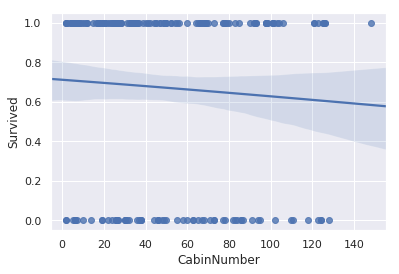

In [4]:
# plot cabin number against survival rate
df = get_cabin_df()
df = df[['Survived', 'CabinNumber']].dropna()
df['CabinNumber'] = df['CabinNumber'].astype('int64')
sns.regplot(x='CabinNumber', y='Survived', data=df, logistic=True)
plt.show()

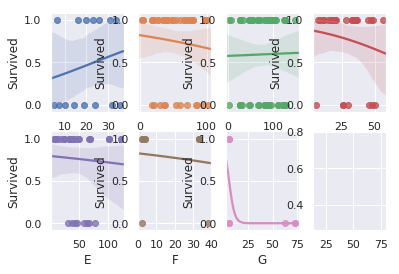

In [6]:
# plot deck against survival rate
df = get_cabin_df()

fig, axes = plt.subplots(nrows=2, ncols=4)

for idx, cc in enumerate(sorted(df['CabinCode'].unique())):
    df3 = df[df['CabinCode'] == cc]
    row = 1 if idx > 3 else 0
    col = (idx - 4) if idx > 3 else idx

    ax = sns.regplot(
        x='CabinNumber',
        y='Survived',
        data=df3,
        logistic=True,
        ax=axes[row, col])
    ax.set(xlabel=cc)
plt.show()

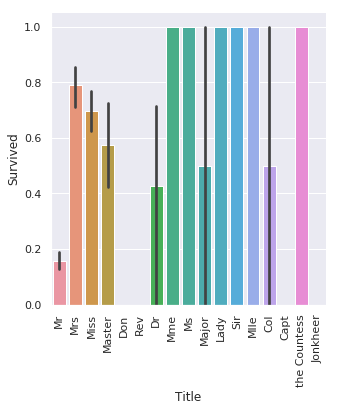

In [8]:
# plot title against survival rate
df = pd.read_csv('data/train.csv')
df = df[['Survived', 'Name']]
df[['FirstName', 'LastName', 'Title']] = get_name_df(df)
g = sns.catplot(x='Title', y='Survived', data=df, kind='bar')
g.set_xticklabels(rotation=90)
plt.show()

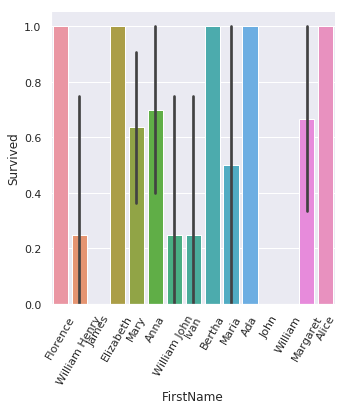

In [12]:
# plot frequently occurring names against survival rate
# TODO: account for frequency of name
df = pd.read_csv('data/train.csv')
df = df[['Survived', 'Name']]
df[['FirstName', 'LastName', 'Title']] = get_name_df(df)
df = df.groupby('FirstName').filter(lambda x: len(x) > 3)
g = sns.catplot(x='FirstName', y='Survived', data=df, kind='bar')
g.set_xticklabels(rotation=60)
plt.show()

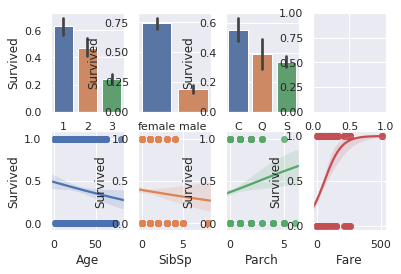

In [21]:
# plot different numeric and categorical variables against survival rate
def plot_basic_numerical_categorical(df, cat_cols, num_cols,
                                     target='Survived'):
    fig, axes = plt.subplots(nrows=2, ncols=4)

    plt_conf = [
        *[{
            'name': c,
            'plt_type': 'barplot',
        } for c in cat_cols],
        *[{
            'name': c,
            'plt_type': 'regplot'
        } for c in num_cols],
    ]

    for idx, col in enumerate(plt_conf):
        kwargs = dict(x=col['name'], y=target, data=df)
        if col['plt_type'] == 'barplot':
            fn = sns.barplot
            kwargs['ax'] = axes[0, idx]
        else:
            fn = sns.regplot
            kwargs['logistic'] = True
            kwargs['ax'] = axes[1, idx - len(cat_cols)]

        fn(**kwargs)

    plt.show()


def plot_cat_num():
    df = pd.read_csv('data/train.csv')

    df = df.drop(['PassengerId', 'Cabin', 'Name'], axis=1)

    cat_cols = ['Pclass', 'Sex', 'Embarked']
    df[cat_cols] = df[cat_cols].astype('category')

    num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    plot_basic_numerical_categorical(df, cat_cols, num_cols)


plot_cat_num()

In [42]:
df = pd.read_csv('data/train.csv')

# separate out names
df[['FirstName', 'LastName', 'Title']] = get_name_df(df)

# ignore PassengerId, Name, Ticket, Cabin, First/LastName
# too many empty Cabin values!
cat_cols = ['Pclass', 'Sex', 'Embarked', 'Title']
num_cols = ['Fare', 'Parch', 'SibSp', 'Age']
keep_cols = cat_cols + num_cols + ['Survived']
df = df[keep_cols]

# update dtypes
df[cat_cols] = df[cat_cols].astype('category')

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().values[0])

In [45]:
# simple logistic regression model w/o validation on numerical value columns 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

target = 'Survived'

X = df.drop([target, *cat_cols], axis=1)
y = df[target]

# fit logistic regression model to data
clf.fit(X, y)

clf.score(X, y)

# 70% accuracy on training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Fare     891 non-null float64
Parch    891 non-null int64
SibSp    891 non-null int64
Age      891 non-null float64
dtypes: float64(2), int64(2)
memory usage: 27.9 KB


0.691358024691358

In [46]:
# simple logistic regression model w/ validation on numerical and categorical data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

target = 'Survived'

X = df.drop([target, *cat_cols], axis=1)

for c in cat_cols:
    dummies = pd.get_dummies(df[c])
    X = pd.concat([X, dummies], axis=1)
    
y = df[target]

clf.fit(X, y)

clf.score(X, y)

# 83% accuracy on training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 29 columns):
Fare            891 non-null float64
Parch           891 non-null int64
SibSp           891 non-null int64
Age             891 non-null float64
1               891 non-null uint8
2               891 non-null uint8
3               891 non-null uint8
female          891 non-null uint8
male            891 non-null uint8
C               891 non-null uint8
Q               891 non-null uint8
S               891 non-null uint8
Capt            891 non-null uint8
Col             891 non-null uint8
Don             891 non-null uint8
Dr              891 non-null uint8
Jonkheer        891 non-null uint8
Lady            891 non-null uint8
Major           891 non-null uint8
Master          891 non-null uint8
Miss            891 non-null uint8
Mlle            891 non-null uint8
Mme             891 non-null uint8
Mr              891 non-null uint8
Mrs             891 non-null uint8
Ms              

0.8305274971941639

In [52]:
# Kaggle provides a test.csv, but to avoid converting above cells to a scikit pipeline right now,
# just train-test split our ~891 training sample
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf = LogisticRegression()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8161434977578476

In [51]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf = LogisticRegression()
clf.fit(X_train, y_train)

cross_val_score(clf, X_test, y_test, cv=5).mean()

0.8250129198966407

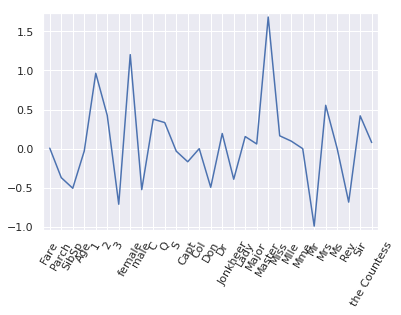

In [58]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

# plot feature names along x-axis, their coefficient values along y
plt.plot(range(len(X_train.columns)), clf.coef_[0])
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

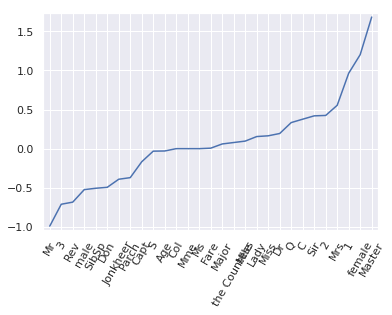

In [59]:
# plot feature names along x-axis, their coefficient values along y, as above
# but this time order it so highest coefficients occur as x-axis values increase
clf = LogisticRegression()
clf.fit(X_train, y_train)

inputs = zip(X_train.columns.values, clf.coef_[0])

inputs = sorted(inputs, key=lambda t: t[1])
feat_names, coefs = zip(*inputs)

# plot feature names along x-axis, their coefficient values along y
plt.plot(range(len(X_train.columns)), coefs)
plt.xticks(range(len(X_train.columns)), feat_names, rotation=60)
plt.margins(0.02)
plt.show()